In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))

In [ ]:
# %%
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, BatchSampler
import matplotlib.pyplot as plt
import os

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, mfg):
        """
        GRUNet model for return prediction
        mfg: model config file
        """
        super(GRUNet, self).__init__()


        self.hidden_dim = mfg.hidR
        self.n_layers = mfg.layer_nums
        self.input_dim = mfg.feature_nums
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(self.hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.fc(out)
        return out

class Combined_GRUNet(nn.Module):
    def __init__(self, mfg, pretrained_net=None):
        """
        GRUNet model for return prediction
        mfg: model config file
        """
        super(Combined_GRUNet, self).__init__()


        self.hidden_dim = mfg.hidR
        self.n_layers = mfg.layer_nums
        self.input_dim = mfg.feature_nums
        self.pretrain_net = pretrained_net
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(self.hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, 1)

    def forward(self, x, x_lf):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.fc(out)
        out_lf = self.pretrain_net(x_lf)
        return out + out_lf

In [ ]:
# %%

class TimeseriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return self.X.__len__()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

class MultiTimeseriesDataset(Dataset):
    def __init__(self, X1: np.ndarray,  X2: np.ndarray,y: np.ndarray):
        self.X1 = torch.tensor(X1).float()
        self.X2 = torch.tensor(X2).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return self.X1.__len__()

    def __getitem__(self, index):
        return self.X1[index], self.X2[index], self.y[index]

In [ ]:

class corr_loss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def cov(self, x, y):
        assert x.shape[0] == y.shape[0]
        return (x - x.mean()).squeeze()@(y - y.mean()).squeeze()

    def forward(self, y, y_pred):
        return -(self.cov(y, y_pred)/torch.sqrt(self.cov(y, y)*self.cov(y_pred, y_pred)))


====================== Train 1 round ======================


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10, Train Loss: -0.0745, Val Loss: -0.0217
Epoch 20, Train Loss: -0.0987, Val Loss: -0.0215
Epoch 30, Train Loss: -0.0984, Val Loss: -0.0182
Early stopping triggered.


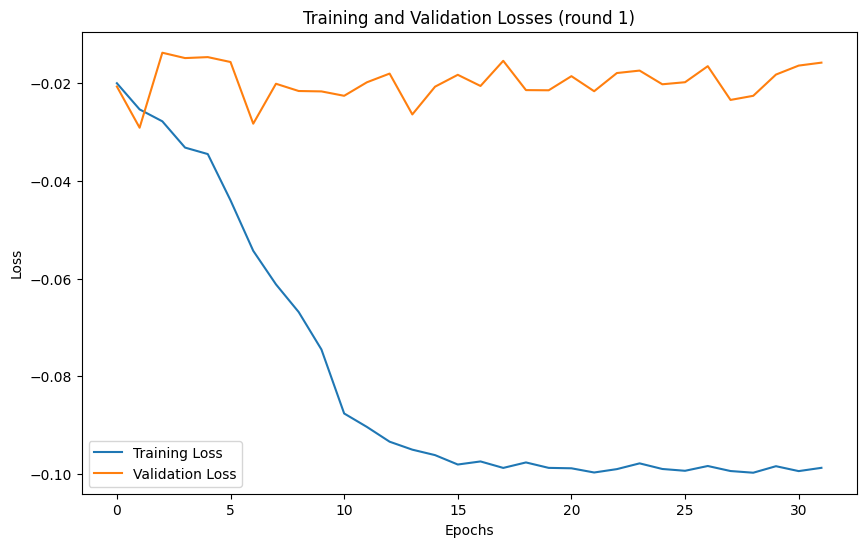

Predicted mean squared error: 16.3051
Predicted cross-section IC: 0.0016


In [ ]:
for i in [1]:  # Loop through datasets 1 to 2
    # Load training data
    x_train = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_train_{i}.npy', allow_pickle=True)
    y_train = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_train_{i}.npy', allow_pickle=True)

    # Load validation data
    x_val = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_val_{i}.npy', allow_pickle=True)
    y_val = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_val_{i}.npy', allow_pickle=True)
    val_label = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/idx_val_{i}.npy', allow_pickle=True)
    val_code = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/code_val_{i}.npy', allow_pickle=True)



    # Configuration file for 1d gru
    class lf_config: pass
    lf_mfg = lf_config()
    lf_mfg.layer_nums = 2
    lf_mfg.hidR = 32
    lf_mfg.feature_nums = 5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_1d = GRUNet(lf_mfg).to(device)
    # Define loss function and optimizer
    criterion = corr_loss()
    optimizer = torch.optim.Adam(model_1d.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    train_dataset = TimeseriesDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
    val_dataset = TimeseriesDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)

    # Train and evaluate the model
    # Train daily frequency model
    num_epochs = 500
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    print(f'====================== Train {i} round ======================')
    for epoch in range(num_epochs):
        # Training loop
        model_1d.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model_1d(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model_1d.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model_1d(x_val)
                val_loss += criterion(val_outputs, y_val).item()
        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)

        # Save the best model
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss

            model_save_path = f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_rolling_3_{i}.pth'
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

            # Now you can safely save your model
            torch.save(model_1d.state_dict(), model_save_path)
            #torch.save(model_1d.state_dict(), './models/model_gru_1d_tpphrm.pth')

        # Early stopping condition
        if epoch > 0 and val_losses[-1] > val_losses[-2]:
            early_stop_counter += 1
        else:
            early_stop_counter = 0
        if early_stop_counter == 4:
            print("Early stopping triggered.")
            break

        if (epoch+1) % 10 == 0:
          print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        scheduler.step()
    # Plotting the training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses (round {i})')
    plt.legend()
    # Save the figure
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/plot_3/training_validation_loss_curve(round {i}).png')
    plt.show()

    #%%
    # Configuration file for 1d gru
    class lf_config: pass
    lf_mfg = lf_config()
    lf_mfg.layer_nums = 2
    lf_mfg.hidR = 32
    lf_mfg.feature_nums = 5

    model_1d = GRUNet(lf_mfg)

    state_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_rolling_3_{i}.pth')
    model_1d.load_state_dict(state_dict)  # Make sure model_1d is your model instance

    # After training and evaluation, load test data and perform predictions
    x_test = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_test_{i}.npy', allow_pickle=True)
    y_test = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_test_{i}.npy', allow_pickle=True)
    test_label = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/idx_test_{i}.npy', allow_pickle=True)
    test_code = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/code_test_{i}.npy', allow_pickle=True)

    # Convert numpy arrays to tensors, ensure they are in the correct format, and perform predictions as outlined
    x_val = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_val_{i}.npy', allow_pickle=True)
    x_val = torch.from_numpy(x_val).float()
    x_test = torch.from_numpy(x_test).float()


    with torch.no_grad():
        y_pred_test = model_1d(x_test).numpy().ravel()
        y_pred_val = model_1d(x_val).numpy().ravel()
    # After obtaining predictions, construct DataFrames for results and observed values, pivot them, and calculate IC
    test_res = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_pred_test.tolist()]).T, columns=['date', 'code', 'fac'])
    test_obs = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_test.tolist()]).T, columns=['date', 'code', 'fac'])

    # Calculate the squared error between two lists
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_test.tolist(), y_pred_test.tolist())]
    mean_squared_error = sum(squared_errors) / len(squared_errors)
    print(f"Predicted mean squared error: {mean_squared_error:.4f}")



    val_res = pd.DataFrame(np.array([val_label.tolist(), val_code.tolist(), y_pred_val.tolist()]).T, columns=['date', 'code', 'fac'])

    test_res['fac'] = pd.to_numeric(test_res['fac'], errors='coerce').fillna(0)
    val_res['fac'] = pd.to_numeric(val_res['fac'], errors='coerce').fillna(0)
    test_obs['fac'] = pd.to_numeric(test_obs['fac'], errors='coerce').fillna(0)

    test_res_pivot = test_res.pivot(index='date', columns='code', values='fac').fillna(0)
    test_obs_pivot = test_obs.pivot(index='date', columns='code', values='fac').fillna(0)
    ic = test_res_pivot.corrwith(test_obs_pivot).mean()

    # Prediction cross-section IC
    print(f"Predicted cross-section IC: {ic:.4f}")


    test_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/result/test_res_rolling_3_round_{i}.csv')
    val_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/result/val_res_rolling_3_round_{i}.csv')


====================== Train 2 round ======================


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10, Train Loss: -0.0675, Val Loss: -0.0248
Epoch 20, Train Loss: -0.0928, Val Loss: -0.0253
Epoch 30, Train Loss: -0.0929, Val Loss: -0.0243
Epoch 40, Train Loss: -0.0915, Val Loss: -0.0214
Epoch 50, Train Loss: -0.0911, Val Loss: -0.0240
Epoch 60, Train Loss: -0.0914, Val Loss: -0.0261
Epoch 70, Train Loss: -0.0923, Val Loss: -0.0245
Epoch 80, Train Loss: -0.0909, Val Loss: -0.0224
Epoch 90, Train Loss: -0.0912, Val Loss: -0.0222
Epoch 100, Train Loss: -0.0922, Val Loss: -0.0243
Epoch 110, Train Loss: -0.0925, Val Loss: -0.0231
Epoch 120, Train Loss: -0.0912, Val Loss: -0.0272
Epoch 130, Train Loss: -0.0905, Val Loss: -0.0253
Epoch 140, Train Loss: -0.0924, Val Loss: -0.0231
Epoch 150, Train Loss: -0.0918, Val Loss: -0.0240
Epoch 160, Train Loss: -0.0929, Val Loss: -0.0236
Epoch 170, Train Loss: -0.0911, Val Loss: -0.0260
Epoch 180, Train Loss: -0.0914, Val Loss: -0.0275
Epoch 190, Train Loss: -0.0914, Val Loss: -0.0202
Epoch 200, Train Loss: -0.0911, Val Loss: -0.0205
Epoch 210

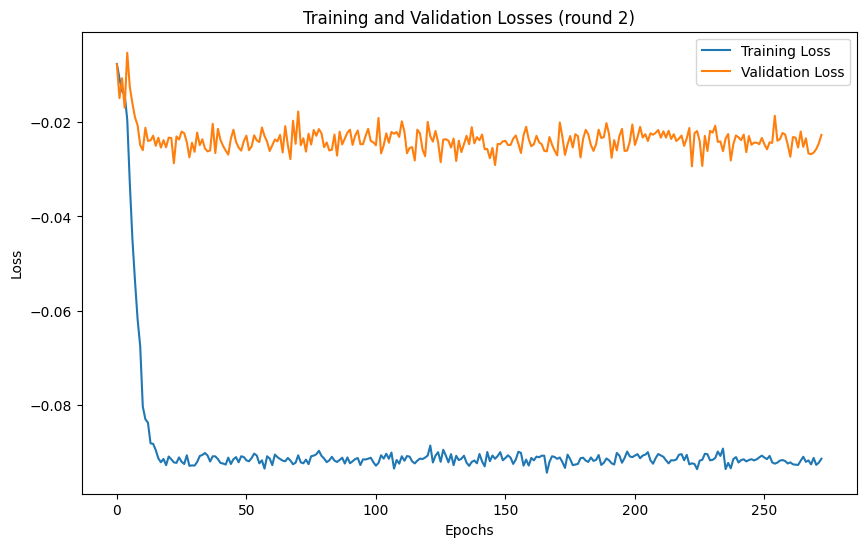

Predicted mean squared error: 5.4188
Predicted cross-section IC: 0.0138


In [ ]:
for i in [2]:  # Loop through datasets 1 to 2
    # Load training data
    x_train = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_train_{i}.npy', allow_pickle=True)
    y_train = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_train_{i}.npy', allow_pickle=True)

    # Load validation data
    x_val = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_val_{i}.npy', allow_pickle=True)
    y_val = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_val_{i}.npy', allow_pickle=True)
    val_label = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/idx_val_{i}.npy', allow_pickle=True)
    val_code = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/code_val_{i}.npy', allow_pickle=True)



    # Configuration file for 1d gru
    class lf_config: pass
    lf_mfg = lf_config()
    lf_mfg.layer_nums = 2
    lf_mfg.hidR = 32
    lf_mfg.feature_nums = 5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_1d = GRUNet(lf_mfg).to(device)
    # Define loss function and optimizer
    criterion = corr_loss()
    optimizer = torch.optim.Adam(model_1d.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    train_dataset = TimeseriesDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
    val_dataset = TimeseriesDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)

    # Train and evaluate the model
    # Train daily frequency model
    num_epochs = 500
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    print(f'====================== Train {i} round ======================')
    for epoch in range(num_epochs):
        # Training loop
        model_1d.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model_1d(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model_1d.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model_1d(x_val)
                val_loss += criterion(val_outputs, y_val).item()
        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)

        # Save the best model
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss

            model_save_path = f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_rolling_3_{i}.pth'
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

            # Now you can safely save your model
            torch.save(model_1d.state_dict(), model_save_path)
            #torch.save(model_1d.state_dict(), './models/model_gru_1d_tpphrm.pth')

        # Early stopping condition
        if epoch > 0 and val_losses[-1] > val_losses[-2]:
            early_stop_counter += 1
        else:
            early_stop_counter = 0
        if early_stop_counter == 4:
            print("Early stopping triggered.")
            break

        if (epoch+1) % 10 == 0:
          print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        scheduler.step()
    # Plotting the training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses (round {i})')
    plt.legend()
    # Save the figure
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/plot_3/training_validation_loss_curve(round {i}).png')
    plt.show()

    #%%
    # Configuration file for 1d gru
    class lf_config: pass
    lf_mfg = lf_config()
    lf_mfg.layer_nums = 2
    lf_mfg.hidR = 32
    lf_mfg.feature_nums = 5

    model_1d = GRUNet(lf_mfg)

    state_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_rolling_3_{i}.pth')
    model_1d.load_state_dict(state_dict)  # Make sure model_1d is your model instance

    # After training and evaluation, load test data and perform predictions
    x_test = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_test_{i}.npy', allow_pickle=True)
    y_test = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/y_test_{i}.npy', allow_pickle=True)
    test_label = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/idx_test_{i}.npy', allow_pickle=True)
    test_code = np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/code_test_{i}.npy', allow_pickle=True)

    # Convert numpy arrays to tensors, ensure they are in the correct format, and perform predictions as outlined
    x_val = 100 * np.load(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_rolling_3/x_val_{i}.npy', allow_pickle=True)
    x_val = torch.from_numpy(x_val).float()
    x_test = torch.from_numpy(x_test).float()


    with torch.no_grad():
        y_pred_test = model_1d(x_test).numpy().ravel()
        y_pred_val = model_1d(x_val).numpy().ravel()
    # After obtaining predictions, construct DataFrames for results and observed values, pivot them, and calculate IC
    test_res = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_pred_test.tolist()]).T, columns=['date', 'code', 'fac'])
    test_obs = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_test.tolist()]).T, columns=['date', 'code', 'fac'])

    # Calculate the squared error between two lists
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_test.tolist(), y_pred_test.tolist())]
    mean_squared_error = sum(squared_errors) / len(squared_errors)
    print(f"Predicted mean squared error: {mean_squared_error:.4f}")



    val_res = pd.DataFrame(np.array([val_label.tolist(), val_code.tolist(), y_pred_val.tolist()]).T, columns=['date', 'code', 'fac'])

    test_res['fac'] = pd.to_numeric(test_res['fac'], errors='coerce').fillna(0)
    val_res['fac'] = pd.to_numeric(val_res['fac'], errors='coerce').fillna(0)
    test_obs['fac'] = pd.to_numeric(test_obs['fac'], errors='coerce').fillna(0)

    test_res_pivot = test_res.pivot(index='date', columns='code', values='fac').fillna(0)
    test_obs_pivot = test_obs.pivot(index='date', columns='code', values='fac').fillna(0)
    ic = test_res_pivot.corrwith(test_obs_pivot).mean()

    # Prediction cross-section IC
    print(f"Predicted cross-section IC: {ic:.4f}")


    test_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/result/test_res_rolling_3_round_{i}.csv')
    val_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/result/val_res_rolling_3_round_{i}.csv')
